# Speech Recognition using Graphs

Team members: Adrian Löwenstein, Kiran Bacsa, Manuel Vonlanthen<br>
Date:         22.01.2018

# Important Prior Information

To be able to rerun this notebook the function files "cut_audio.py" and "main_pipeline.py" (provided in the uploaded .zip file)have to be located inside the working path. In addition, the entire used data set, as well as a pickle file containing all extracted features from it can be downloaded [here](https://drive.switch.ch/index.php/s/Gfw94SHFEgGUOvn). For recomputation purposes the pickle file has to be located in a folder called "Features Data", which in turn has to be located in the working path. The dataset containing all audio files (circa 2 GB) has to be located at ..\Data\. 

## Problem Description

In this section we will describe in detail the problem we studied during the final project of the course "Network Tour of Data Science". We wanted to do speech recognition using the Graph/Network theory learned during the course. We were inspired by the kaggle competition "Tensor Flow Speech Recognition Challenge: Can you build an algorithm that understands simple speech commands" put up by google. In said competition the goal was to classify 20 distinct words. Words that do not belong to any of the 20 classes should be classified as "unknown". For the kaggle competition the TensorFlow library had to be used. For this purpose Google provided a large training data set (64'720 audio files) with known labels and an even larger test (150'000+ audio files) with unknown labels for them to evaluate the built algorithms. We, however, decided to only work with the provided training data, because the data set is large enough to perform statistically valid model evaluation and it this we we weren't dependant on the kaggle competition.<br>
<br>
The provided data set consists of 64'720 .wave files of length 1s, sampled with a sampling rate of $16$ kHz. Each audio files contain one of 30 possible spoken words. The files were created using crowd-sourcing, which means that the conditioning of the audio signal is not equal for all audio files. This led to very different noise levels, amplitudes, etc. Also the same speaker might have recorded different audio files. The 20 core words which have to be classified correctly are:

    - up, down
    - zero, one, two, three, four, five ,six ,seven, eight, nine
    - go, stop 
    - left, rigth
    - no, yes
    - off, on
In addition to these 20 words, 10 other words were provided inside the training set to train the algorithm to classify words which it should not react to as "unknown". The following "unknown" words are contained in the training data:

    - bed
    - bird, cat, dog, mouse
    - tree
    - happy
    - marvin, sheila
    - wow
<br>
At this point we want to empphasize that we did not study the problem suggested for the kaggle competition, but a slightly simplified one. First of all we did not restrict ourselves to using TensorFlow, in fact we did not use it at all. However, we did restrict ourselves to use Graph theory as central part of our classification algorithm. Our goal was, using only the provided training set, to build a classifier which calssifies the above listed core words as accurate as possible. In addition, all other words (the 10 additional words) should be classified as "unknown". This means we wanted to build a "word"-classifier for 21 different classes using graph theory.<br>
<br>
Mathematically, we can define the task as follows. We split up our training data set into a training set $S_t$ of some size N (we will later comment on its size) and a validation set $S_v$ of size $V \leq 64'720-N$, used to check how well the classifier works.
Using $\mathbf{x_n} \in S_t$, which is some training audio file $\mathbf{x_n} \in \mathbb{R}^D$, where $D = 1s\cdot 16kHz = 16000$ is the number of samples per audio file, we can build our training data matrix $\mathbf{X}^{\mathbf{N\times D}}$. Using $\mathbf{X}$ we want to learn a function $f(\mathbf{v_v}, \mathbf{X}): \mathbb{R}^{N+1\times D} \to \{1,2,3,...,21\}$, where $\mathbf{v_v}\in S_v$ is a validation audio file $\mathbf{v_v}\in\mathbb{R}^D$, such that the resulting estimated label $\hat{y_v} = f(\mathbf{v_V}, \mathbf{X})$ is equal to the correct label $y_v \in \{1,2,3,...,21\}$ for as many validation samples as possible. Hence, we use the accuracy measure defined as
$$acc = \frac{\sum_{i=1}^{K}\max[\min[(|y_k-\hat{y_k}|),1],0]}{K},$$
where $K$ is the number of tested samples $v_k$. We want to remark that the model could also work with a subset $\mathbb{v}\subseteq S_v$ (batch) instead of a single validation file $v_v$. In this case we define the cardinality of said subset $|\mathbb{v}|=K$ and the model would correspond to $f(\mathbb{v}, \mathbf{X}): \mathbb{R}^{(N+K)\times D} \to \{1,2,3,...,21\}^K$.

## Imports

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

# Self_made functions
from main_pipeline import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (17, 5)

## Recompute

**WARNING** If you set recompute to True this will reextract all featrues, which will take approiximately a days, so we do not recommend it. It is here for completeness so you can see how the step was done during th project. We've already computed it and saved the results into a pickle file. Our entire used data, as well as the pickle files can be found [here](https://drive.switch.ch/index.php/s/Gfw94SHFEgGUOvn).<br>

In [2]:
recompute = False

## Feature Extraction

The **Dataset** that was taken from the Kaggle competition was initally separated in 2 sets. A Training Set containing labeled test words from different speakers with various background noises. The test set contains unlabeled data, and will not be used with this project as it won't allow the calculation of the accuracy. In the following we will only use the original training set as our main dataset. The words are provided in the form of a .wav sound file of 1 second.  <br> 

Feature Extraction **Pipeline** : 
1. We first analyse the dataset and save into a dataframe for each word :  the path, the label and the id of the speaker. 
2. We then import the audio content using Librosa and store it into this dataframe. 
3. Next we proceed to the cleaning of the data by cutting the silences before and after the words are pronounced. 
4. Finally we compute the main features : the MFCCs that are then stored into a pickle. 

As for the feature chosen, we have kept only the MFCCs of the audio file. Other features we considered as the MFCCs for the whole audio file (instead of the cut version), or the statistics on the MFCCs . 

Recomputing the whole Feature Extraction and Computation : 

In [3]:
# Conditional recomputing : (WARNING : THIS TAKES MORE THAN 24H)
if recompute == True : 
    
    # Extracts and cuts the audio files from the folder to store it inside a set of pickles
    main_train_audio_extraction()
    
    # Computes the features from the previously extracted audio files. Save them into a single pickle. 
    main_train_audio_features()

Pipeline for a small number of audio files : 

In [4]:
N = 2

train_audio_path = '../Data/train/audio'
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

path = []
word = []
speaker = []
iteration = []

for direct in dirs:
    if not direct.startswith('_'):
        # Random selection of N files per folder 
        list_files = os.listdir(join(train_audio_path, direct))
        wave_selected  = list(np.random.choice([ f for f in list_files if f.endswith('.wav')],N,replace=False))
        
        # Extraction of file informations for dataframe
        word.extend(list(np.repeat(direct,N,axis=0)))
        speaker.extend([wave_selected[f].split('.')[0].split('_')[0] for f in range(N) ])
        iteration.extend([wave_selected[f].split('.')[0].split('_')[-1] for f in range(N) ])
        path.extend([train_audio_path + '/' + direct + '/' + wave_selected[f] for f in range(N)])
        
# Creation of the Main Dataframe : 
features_og = pd.DataFrame({('info','word',''): word,
                    ('info','speaker',''): speaker,
                    ('info','iteration',''): iteration,
                    ('info','path',''): path})
index_og = [('info','word',''),('info','speaker',''),('info','iteration','')]
features_og.head()

info                                                                
  iteration                                            path   speaker  word
                                                                           
0         0   ../Data/train/audio/bed/f0ebef1b_nohash_0.wav  f0ebef1b   bed
1         0   ../Data/train/audio/bed/187af8be_nohash_0.wav  187af8be   bed
2         0  ../Data/train/audio/bird/becd5a53_nohash_0.wav  becd5a53  bird
3         0  ../Data/train/audio/bird/7061c7d1_nohash_0.wav  7061c7d1  bird
4         2   ../Data/train/audio/cat/c08e5058_nohash_2.wav  c08e5058   cat

After selecting 2 words we normalize their values to their maximum. 

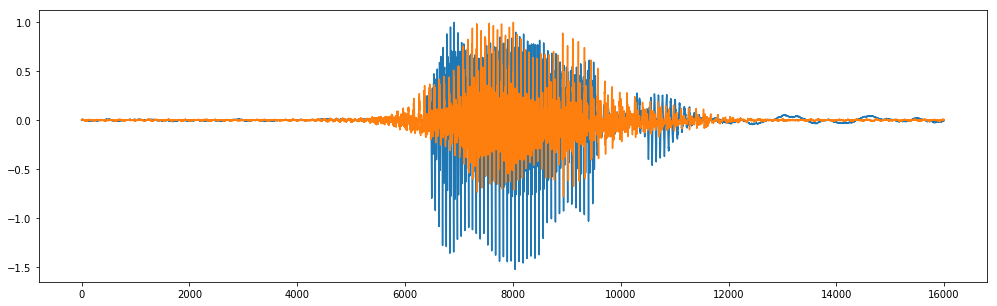

In [5]:
word_1 = 1
word_2 = 59
def get_audio(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return audio, sampling_rate

audio_1, sampling_rate_1 = get_audio(features_og[('info','path')].iloc[word_1])
audio_2, sampling_rate_2 = get_audio(features_og[('info','path')].iloc[word_2])

# normalize audio signals
audio_1 = audio_1/np.max(audio_1)
audio_2  = audio_2/np.max(audio_2)

# Look at the signal in the time domain
plt.plot(audio_1)
plt.hold
plt.plot(audio_2)


In [6]:
# Listen to the first word
ipd.Audio(data=audio_1, rate=sampling_rate_1)

In [7]:
# Listen to the first word
ipd.Audio(data=audio_2, rate=sampling_rate_1)

Next we define two auxiliary function that allow us to select main lobes of the signal and to keep only those lobes. 

In [8]:
def find_lobes(Thresh, audio, shift = int(2048/16)):
    """Finds all energy lobes in an audio signal and returns their start and end indices. The parameter Thresh defines
       the sensitivity of the algforithm."""
    # Compute rmse
    audio = audio/np.max(audio)
    rmse_audio = librosa.feature.rmse(audio, hop_length = 1, frame_length=int(shift*2)).reshape(-1,)
    rmse_audio -= np.min(rmse_audio)
    rmse_audio /= np.max(rmse_audio)
    i_start = np.array([])
    i_end = np.array([])
    for i in range(len(rmse_audio)-1):
        if (int(rmse_audio[i]>Thresh)-int(rmse_audio[i+1]>Thresh)) == -1:
            i_start = np.append(i_start,i)
        elif (int(rmse_audio[i]>Thresh)-int(rmse_audio[i+1]>Thresh)) == 1:    
            i_end = np.append(i_end,i)
    
    if len(i_start) == 0:
        i_start = np.append(i_start,0)
        
    if len(i_end) == 0:
        i_end = np.append(i_end,i)   
    
    if i_start[0]>i_end[0]:
        i_start = np.append(np.array(0), i_start)
        
    if i_start[-1]>i_end[-1]:
        i_end = np.append(i_end,i)
    
    return i_start, i_end, rmse_audio, shift

In [9]:
def cut_signal( audio, Thresh = 0.1, mode = 'proxy',reach = 2000, number_lobes = 2):
    """Extracts relevant parts ofn audio signal.
       The Thresh input value defines the sensitivity of the cut, its value has to be positive.
       Two modes can be chosen:
           - proxy(Default): Finds main energy lobe of the signal and also adds lobes that are within reach. 
                             The reach parameter can be adjusted adn has to be a positive value (default is 2000.)
           - num_lobes:      Finds the highest energy lobes of the signal. The parameter num_lobes (default value 2) 
                             defines how many of the largest lobes are being considered. """
    
    i_start, i_end, rmse_audio, shift = find_lobes(Thresh, audio)
    energy = np.array([])
    for i in range(len(i_start)):
        energy = np.append(energy,sum(rmse_audio[int(i_start[i]):int(i_end[i])]))
    
    if mode is 'num_lobes':
        lobes = np.argsort(energy)[-number_lobes:]
        start = np.min(i_start[lobes])
        end = np.max(i_end[lobes])
    elif mode is 'proxy':
        main_lobe = np.argsort(energy)[-1]
        start = i_start[main_lobe]
        end = i_end[main_lobe]
        for i in range(main_lobe):
            if (i_start[main_lobe]-i_end[i])<reach:
                start = np.min((i_start[i],start))
                
        for i in range(main_lobe,len(i_start)):   
            if (i_start[i]-i_end[main_lobe])<reach:
                end = i_end[i]
        
    else:
        print('ERROR: mode not implemented.')
    
    audio_cut = audio[int(np.max((0,int(start-shift-300)))):int(np.min((int(end)+300,len(audio))))]    
    return audio_cut

For the selection of the lobes we use the RMSE transformation. We next display the shape of those signals after this transformation : 

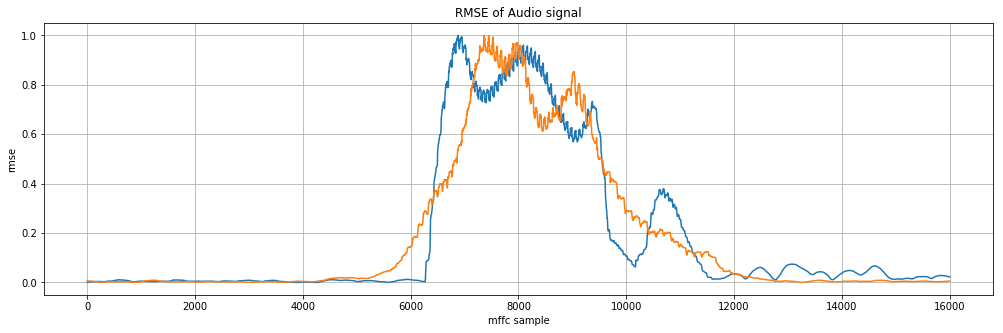

In [10]:
rmse_audio_1 = librosa.feature.rmse(audio_1, hop_length = 1, frame_length=int(2048/8)).reshape(-1,)
rmse_audio_1 -= np.min(rmse_audio_1) 
rmse_audio_1 /= np.max(rmse_audio_1)
plt.plot(rmse_audio_1)
plt.grid()
plt.title('RMSE of Audio signal')
plt.xlabel('mffc sample')
plt.ylabel('rmse')
plt.hold
rmse_audio_2 = librosa.feature.rmse(audio_2, hop_length = 1,  frame_length=int(2048/8)).reshape(-1,)
rmse_audio_2 -= np.min(rmse_audio_2) 
rmse_audio_2 /= np.max(rmse_audio_2)
plt.plot(rmse_audio_2)

Next we apply the our auxiliary function `cut_signal` to the 2 audio samples. As we see it removes efficiently the silence surrounding the main lobes.  

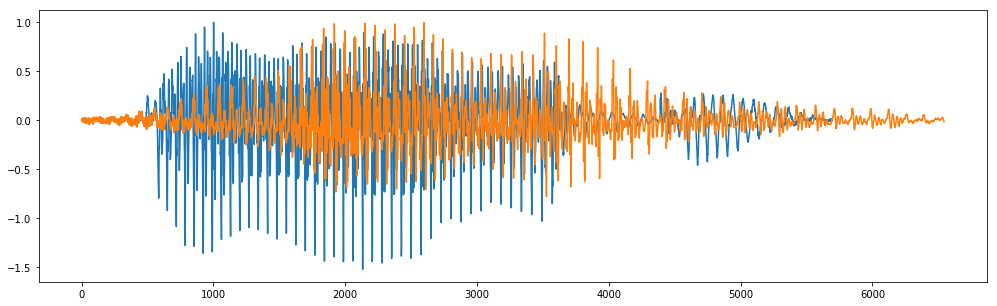

In [11]:
# Cutting above the threshold and keeping the main lobes : 
audio_1_cut = cut_signal(audio_1)
audio_2_cut = cut_signal(audio_2)

# Display cut time signal
plt.plot(audio_1_cut)
plt.hold
plt.plot(audio_2_cut)

In [12]:
print('Cut Version 1 :')
ipd.Audio(data=audio_1_cut, rate=sampling_rate_1)

Cut Version 1 :


In [13]:
print('Cut Version 2 :')
ipd.Audio(data=audio_2_cut, rate=sampling_rate_2)

Cut Version 2 :


Of the cut audio file we want now to compute our features the Mel-Frequency Cepstral Coefficients, short mfccs. For this, no matter the length of the audio file, we compute 20 mfcc vectors of dimension 10. This means we compoute a short-time Fourier transform at 20 equidistant time points inside the cut audio files and keep the lower 10 mfccs of the spectrum. Since the audio files are of different length after the cutting, we adjust the hop-length (length between two short-time Fourier analyses) for every audio file accordingly. this makes the resulting feature vectors comparable and adds a "time warping" effect which should make the feature more robust to slower/faster spoken words.  

In [14]:
N_MFCCS = 10
#n_fft, hop_length
mfccs_1 = librosa.feature.mfcc(y=audio_1_cut,sr=sampling_rate_1, n_mfcc=N_MFCCS, n_fft = int(2048/2), hop_length = int(np.floor(len(audio_1_cut)/20)))
mfccs_2 = librosa.feature.mfcc(y=audio_2_cut,sr=sampling_rate_2, n_mfcc=N_MFCCS, n_fft = int(2048/2), hop_length = int(np.floor(len(audio_2_cut)/20)))
mfccs_1 = mfccs_1[:,:-1]
mfccs_2 = mfccs_2[:,:-1]
print(np.shape(mfccs_1))
print(np.shape(mfccs_2))

(10, 20)
(10, 20)


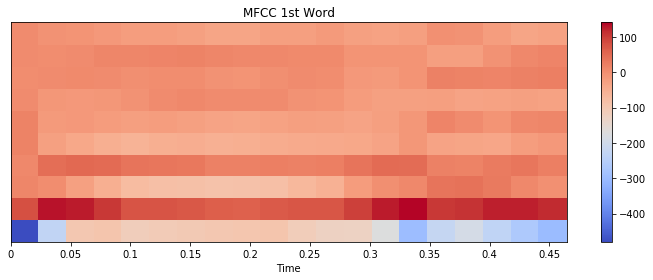

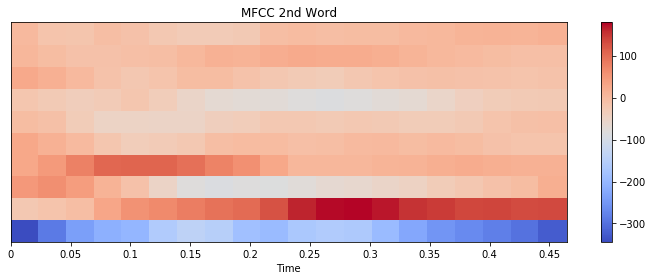

In [15]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_1, x_axis='time')
plt.colorbar()
plt.title('MFCC 1st Word')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_2, x_axis='time')
plt.colorbar()
plt.title('MFCC 2nd Word')
plt.tight_layout()

As we have allready computed the Features for the whole dataset we load it directly from the following pickle file. 

In [16]:
# Load features
features_og = pd.read_pickle('./Features Data/cut_mfccs_all_raw_10_1028_20.pickle')
features_og.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         0  ../Project/data/train/audio/bed/988e2f9a_nohas...  988e2f9a  bed   
1         2  ../Project/data/train/audio/bed/6d818f6c_nohas...  6d818f6c  bed   
2         0  ../Project/data/train/audio/bed/93ec8b84_nohas...  93ec8b84  bed   
3         1  ../Project/data/train/audio/bed/a9abc695_nohas...  a9abc695  bed   
4         0  ../Project/data/train/audio/bed/a8cb6dda_nohas...  a8cb6dda  bed   

      mfcc                                                ...               \
  raw_mfcc                                                ...                
         0        1        2        3        4        5   ...          190   
0 -532.804 -373.747 -281.723 -259.193 -260.494 -258.983   ...       1.9078   
1 -407.218 -255.981  -163.47  -131.31 -112.495  -118.76   ...    -0.523793   
2 -466.171 -337.843 -244.057 -223.569 -248.308 -250.754   ...     -19.4222   
3 -556.172 -371.435 -267.924 -229.983 -221.044 -213.585   ...     -13.8834   
4 -483.963 -384.623 -221.676 -136.899 -108.406 -110.998   ...      9.02163   

                                                                           \
                                                                            
       191      192      193      194      195      196      197      198   
0 -6.68038 -12.3779 -7.88019 -4.89838  5.09246  5.23662  5.81571    2.533   
1 -2.98547  -3.1049 -10.3242 -19.2463 -25.6867 -23.1932 -13.7993 -17.9949   
2 -8.93999 -2.63587 -2.76918 -9.29244 -14.9003 -17.6517 -15.8084 -25.7532   
3 -18.6183 -15.9497 -13.2618 -9.06467 -12.7498 -12.3417 -14.7705 -19.5946   
4  2.85084 -1.81553 -2.05279  0.79797 -2.28227 -10.0107 -13.8224 -10.9754   

            
            
       199  
0  3.65357  
1   -12.81  
2 -30.9885  
3 -22.2862  
4 -9.73626  

[5 rows x 204 columns]

## Classification Methods

Now that we have extracted some meaningful features from the raw data, we want to build a model that uses some training set $S_t$ of cardinality $|S_t|=N$, which can be used to classify the rest of the data (validation set). We've mainly analyzed two methods, "Spectral Clustering" and "Semi-Supervised Clustering", which we will describe in detail in this section.<br>
<br>
We found that using a training set of cardinality $|S_t| = N = 4800$ and a validation batch size of $|\mathbb{v}|= K = 200$ to be both computationally reasonable and yielding good results. This means that we use the same $N$ datapoints (feature vectors of audio files), of which we know the labels, to classify all other audio files (validation set), of which we pretend not to know the labels. The classification of the validation set (size $V$) is done batch-wise, i.e. $K$ files are classified simultaniously and we iterate trough the entire validation set, i.e. $V/k$ iterations are performed. Which $N$ datapoints are chosen to form the training set is determined randomly with a restriction that every word (or class) is represented equally. Thus, for $N = 4800$ we choose $160$ audio samples of every one of the 30 clases/words at random.<br>
<br>
In this section we will classify one batch of size $K = 200$ and while doing that explain both classification methods using graphs in detail.

### Create training set, validation set and Data Matrix 

In a first step, we create the label vector $\mathbf{y}\in\{1,2,3,...,30\}^{64'720}$ for all datapoints. In addition we plot the labels and the distribution of the classes.

We have 64720 datapoints over the entire dataset.


Text(0,0.5,'number of datapoints')

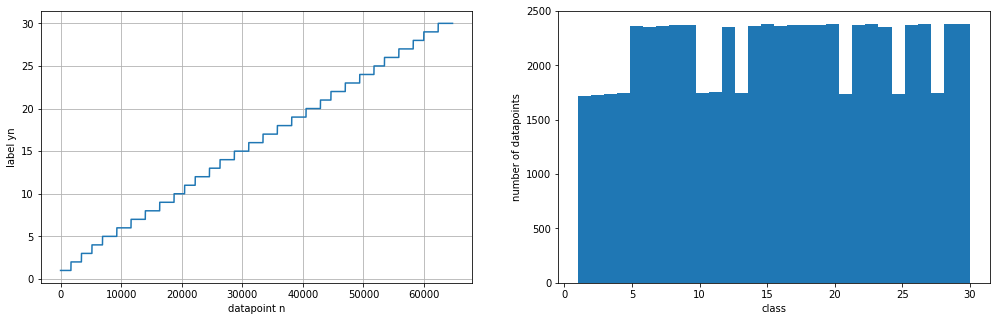

In [17]:
# Build Label vector
# Define class name vector, the index will correspond to the class label
class_names = features_og['info']['word'].unique()
y = np.ones(len(features_og))
for i in range(0,len(class_names)):
    y +=(features_og['info','word'] == class_names[i]) * i
    
# Plot the label vector
print('We have {} datapoints over the entire dataset.'.format(len(y)))
fix, axes = plt.subplots(1, 2, figsize=(17, 5))
axes[0].plot(y)
axes[0].grid()
axes[0].set_xlabel('datapoint n')
axes[0].set_ylabel('label yn')


# Plot distribution of classe
axes[1].hist(y,30)
axes[1].set_xlabel('class')
axes[1].set_ylabel('number of datapoints')

In the above histogram we can see that the classes are not balanced inside the test set. However, for our testing we will chose a balanced training, as well as a balanced validation step. This corresponds to having an equal prior probability of occurence between the different words we want to classify. Thus, in the next cell we choose at random $160$ datapoints per class to form our training set $S_t$ ($30*160=4800$) and $1553$ datapoints per class to form the validation set $S_v$ ($1553*30 = 46590$), which is the maximum amount of datapoints we can put into the vlidation set for it to still be balanced.

In [18]:
# Specify the number of datapoints that should be sampled in each class to build training and validation set
train_size = 160
valid_size = 1553

train_x = np.array([])
train_y = np.array([])

valid_x = np.array([])
valid_y = np.array([])

for i in range(len(class_names)):
    class_index = np.where(y == (i+1))[0]
    random_index = np.random.choice(range(len(class_index)), size=train_size+valid_size, replace=False)
    
    train_x_class = class_index[random_index[:train_size]]
    train_y_class = y[train_x_class]
    train_x = np.append(train_x, train_x_class).astype(int)
    train_y = np.append(train_y, train_y_class).astype(int)

    valid_x_class = class_index[random_index[train_size:train_size+valid_size]]
    valid_y_class = y[valid_x_class]
    valid_x = np.append(valid_x, valid_x_class).astype(int)
    valid_y = np.append(valid_y, valid_y_class).astype(int)

We will define the batch sizem which defines how many validation samples are classified simultaniously. Then we choose at random 200 datapoints of the validation set $S_v$ to build said batch. **Remark**: Although the training and the validation sets are both balanced, the batch itself is not necessarily, because this would be an unreasonable constraint for the task.  

In [19]:
# Define batch size
batch_size = 200

# Choose datapoints from validation set at random to form a batch
potential_elements  = np.array(list(enumerate(np.array(valid_x))))
indices = np.random.choice(potential_elements[:,0].reshape(-1,), batch_size, replace=False)
# The batch index_variable contains the indices of the batch datapoints inside the complete dataset
batch_index = potential_elements[:,1].reshape(-1,)[indices]

Now we build our feature matrix $\mathbf{X}^{(N+K)\times D}$ by concatenating the feature vectors of all datapoints inside the training set $S_t$ and the batch datapoints. The feature are then normalized by substracting their mean, as well as dividing by the standard deviation. The feature normalizing step was found to have a ver significant effect on the resulting classification accuracy. 

In [20]:
# Build data matrix and normalize features
X = pd.DataFrame(features_og['mfcc'], np.append(train_x, batch_index))
X -= X.mean(axis=0)
X /= X.std(axis=0)
print('The data matrix has {} datapoints.'.format(len(X)))

The data matrix has 5000 datapoints.


### Build Graph from Data Matrix

We now want to build a graph from the earlier obtained data matrix. Every node in our graph will correspond to one datapoint (feature vector of one audio file). We use a weighted, undirected graph. The weight is very important for our application, since it gives us a measure of how similair the feature vectors of the two datapoints are. The undirectedeness is a logical conclusion of our edges being similitarity measures, which are inherently undirected.<br>
<br>
To build the weight matrix $W\in \mathbb{R}^{(N+K)\times (N+K)}$ we compute the cosine distance between each datapoint $\mathbf{x_n}$ in the datamatrix $\mathbf{X}$, which is defined as
$$d(\mathbf{x_i},\mathbf{x_j}) = \frac{\mathbf{x_i}^T\mathbf{x_j}}{||\mathbf{x_i}||_2||\mathbf{x_j}||_2}$$
and then build a similarity graph using
$$\mathbf{W_{i,j}} = exp(\frac{-d(\mathbf{x_i},\mathbf{x_j})^2}{\sigma^2}).$$
Other, distance functions were tested, but the cosine distance was found to be the most effective. We used the mean overall distance as $\sigma$.

The weight matrix has a shape of (5000, 5000).


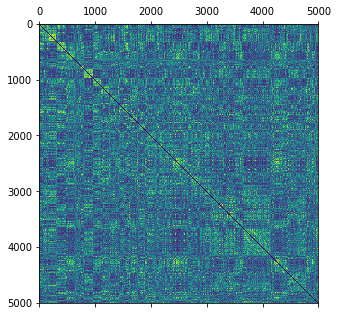

In [21]:
# Compute distances between all datapoints
distances = spatial.distance.squareform(spatial.distance.pdist(X,'cosine'))
n=distances.shape[0]

# Build weight matrix
kernel_width = distances.mean()
W = np.exp(np.divide(-np.square(distances),kernel_width**2))

# Make sure the diagonal is 0 for the weight matrix
np.fill_diagonal(W,0)
print('The weight matrix has a shape of {}.'.format(W.shape))

# Show the weight matrix
plt.matshow(W)

We can already see that there is a distinct square pattern inside the weight matrix. This points to a clustering inside a graph, achieved by good feature extraction (rows and columns are sorted by labels, except last 200). At this point we are ready to present the first classification method that was analyzed: Spectral Clustering.

### Spectral Clustering

Our first approach was to naively reuse the code from assignment 3 : spectral graph theory. By combining all our of samples into a single graph and extracting the resulting graph laplacian, we hope to identify clusters which would correspond to the different words that need to be classified.

Unfortunatly, increasing sparsity has the effect of reducing classification accuracy. We therefore decided to remove k-NN sparsification all together and keep the sample graph as it is.

In [22]:
# compute laplacian
degrees = np.sum(W,axis=0)
laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - W) @ np.diag(degrees**-0.5)
laplacian = sparse.csr_matrix(laplacian)

We can now calculate the eigenvectors of the Laplacian matrix. These eigenvectors will be used as feature vectors for our classifier.

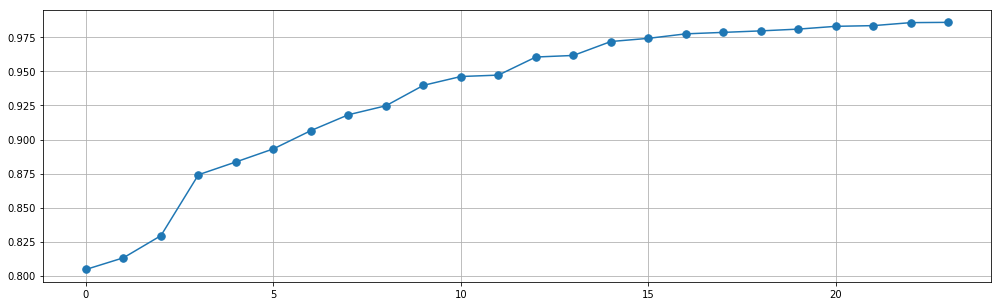

In [23]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=25,which='SM')
plt.plot(eigenvalues[1:], '.-', markersize=15);
plt.grid()

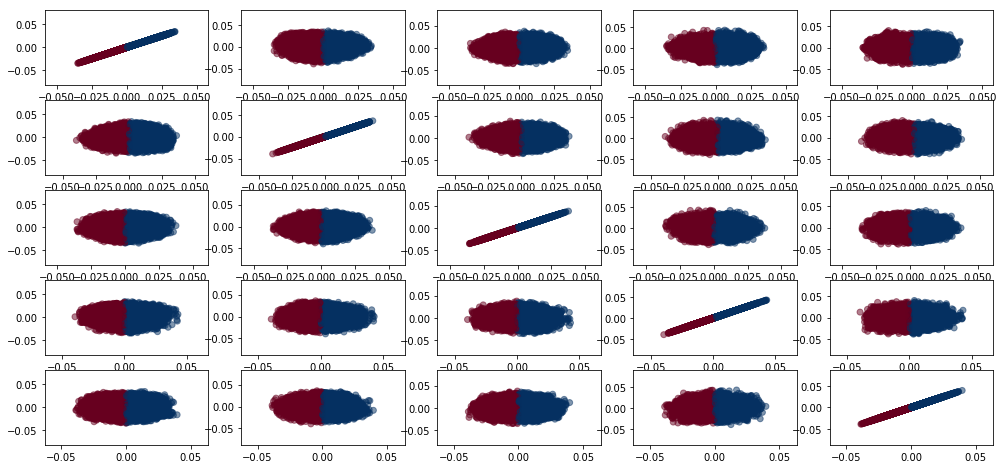

In [24]:
fix, axes = plt.subplots(5, 5, figsize=(17, 8))
for i in range(1,6):
    for j in range(1,6):
        a = eigenvectors[:,i]
        b = eigenvectors[:,j]
        labels = np.sign(a)
        axes[i-1,j-1].scatter(a, b, c=labels, cmap='RdBu', alpha=0.5)

In a next step we split the eigenvectors of the graph into two parts, one containing the nodes representing the training datapoints, one containing the nodes representing the validation datapoints.

In [25]:
# Splitt Eigenvectors into train and validation parts
train_features = eigenvectors[:len(train_x),:]
valid_features = eigenvectors[len(train_x):,:]

A wide range of classifiers were tested on our input features. Remarkably, a very simple classifier such as the [Gaussian Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) produced far better results than more advanced techniques. This is mainly because the graph datapoints were generated using a gaussian kernel, and is therefore sensible to assume that our feature distribution will be gaussian as well. However, the best results were obtained using a [Quadratic Discriminant Analysis classifier](https://en.wikipedia.org/wiki/Quadratic_classifier).

In [26]:
def fit_and_test(clf, train_x, train_y, test_x, test_y):
    clf.fit(train_x, train_y)  
    predict_y = clf.predict(test_x)
    print('accuracy : ', np.sum(test_y==predict_y)/len(test_y))
    return predict_y

In [27]:
clf = GaussianNB()
predict_y = fit_and_test(clf, train_features, train_y, valid_features, np.array(y[batch_index]))

accuracy :  0.665


In [28]:
clf = QuadraticDiscriminantAnalysis()
predict_y = fit_and_test(clf, train_features, train_y, valid_features, np.array(y[batch_index]))

accuracy :  0.82


Once our test set has been classified we can visualize the effectiveness of our classification using a confusion matrix.

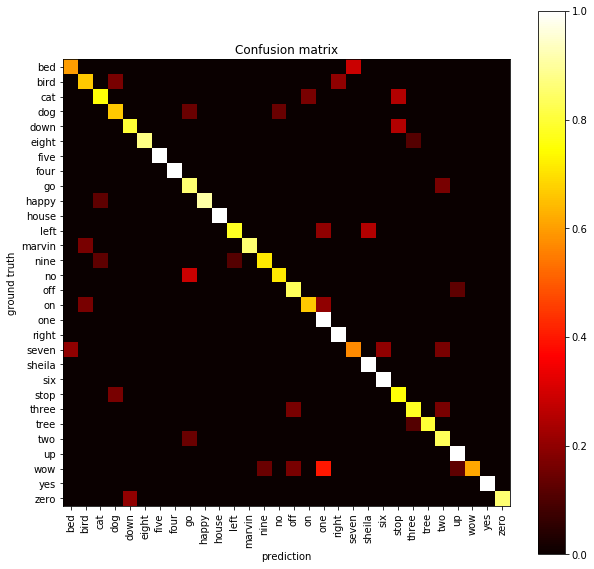

In [29]:
def plot_confusion_matrix(test_y, predict_y, class_names):

    conf_mat=confusion_matrix(test_y,predict_y)

    plt.figure(figsize=(10,10))
    plt.imshow(conf_mat/np.sum(conf_mat,axis=1),cmap=plt.cm.hot)
    tick = np.arange(len(class_names))
    plt.xticks(tick, class_names,rotation=90)
    plt.yticks(tick, class_names)
    plt.ylabel('ground truth')
    plt.xlabel('prediction')
    plt.title('Confusion matrix')
    plt.colorbar()
    
plot_confusion_matrix(np.array(y[batch_index]), predict_y, class_names)

Finally we can focus on the core words that need to be classified and label the rest as 'unknown'.



In [30]:
def adapt_labels(x_hat):
    # Real accuracy considering only the main words :
    class_names_list = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    mask_names_main = [True if name in class_names_list else False for name in class_names]
    index_names_main = [i for i in range(len(mask_names_main)) if mask_names_main[i] == True]
    inverted_index_names = dict(zip(index_names_main,range(len(index_names_main))))

    # Creating the label names :
    class_names_main = class_names[mask_names_main].tolist()
    class_names_main.extend(["unknown"])

    # Adapting the labels in the test and prediction sets :
    return np.array([inverted_index_names[int(x_hat[i])] if x_hat[i] in index_names_main else len(class_names_main)-1 for i in range(len(x_hat)) ]),class_names_main

valid_y_adapted, class_names_main = adapt_labels(np.array(y[batch_index]))
predict_y_adapted, class_names_main = adapt_labels(predict_y)

In [31]:
acc_adapted = np.sum(valid_y_adapted==predict_y_adapted)/len(valid_y_adapted)
print('accuracy for main words classification : ', acc_adapted)

accuracy for main words classification :  0.84


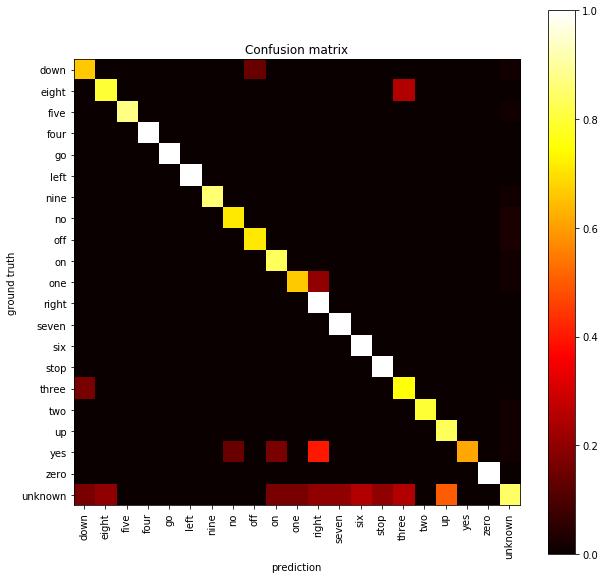

In [32]:
plot_confusion_matrix(valid_y_adapted,predict_y_adapted, class_names_main)

In conclusion, we can say that, using spectral clustering, we were able to leverage the properties of graph theory to find relevant features in speech recognition. However, the accuracy achieved with our model is too far low for any practical applications. Moreover, this model does not benefit from sparsity, meaning that it will not be able to scale with large datasets.

### Semi-Supervised classification

Now that we have seen the spectral clustering method, we want to present the semi-supervised classification method. For this we start by using the same training set $S_t$, validation set $S_v$, batch and Laplaian, as we used to explain the spectral clustering method.<br>
<br>
Unlike for spectral clustering, for this method sparsifying the graph is very important. We noticed a significant increase in classificatiion accuracy using quite sparse graphs. Thus we now sparsify the graph, to have a more significant clustering. We use k-nearest neighbors approach for this.For the purpose of explaining the method we will keep $120$ strongest neighbors of each node. 

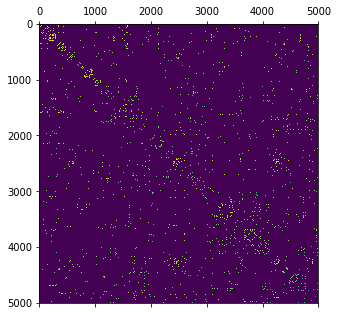

In [33]:
# Sparsify using k- nearest neighbours and make sure it stays symmetric
NEIGHBORS = 120

# Make sure
for i in range(W.shape[0]):
    idx = W[i,:].argsort()[:-NEIGHBORS]
    W[i,idx] = 0
    W[idx,i] = 0

plt.matshow(W) 

We can see that the sparsifyied weight matrix is very focused on its diagonal. We will now build the normalized Laplacian, since it is the core graph feature we will use for semi-supervised classification. The normalized Laplacian is defined as
$$L = \mathbf{I}-\mathbf{D}^{-1/2}\mathbf{W}\mathbf{D}^{-1/2},$$
where $\mathbf{I}$ is the $(N+K)\times (N+K)$ identity matrix and $\mathbf{D}\in \mathbb{N}^{(N+K)\times (N+K)}$ is the degree matrix of the graph.

In [34]:
# Build normalized Laplacian Matrix
D = np.sum(W,axis=0)
L = np.diag(D**-0.5) @ (np.diag(D) - W) @ np.diag(D**-0.5)
L = sparse.csr_matrix(L)

For the semi-supervised classification approach, we now want to transform the label vector of our training data $\mathbf{y_t} \in \{1,2,...,30\}^{N}$ into a matrix $\mathbf{Y_t}\in \{0,1\}^{30\times N}$. Each row $i$ of the matrix $\mathbf{Y_t}$ contains an indicator vector $\mathbf{y_{t,i}}\in\{0,1\}^N$ for class $i$, which means it contains a vector which specifyies for each training node in the graph if it belongs to node $i$ or not. 

In [35]:
# Build one-hot encoded class matrix
Y_t = np.eye(len(class_names))[train_y - 1].T
print('The shape of the new label matrix Y is {}, its maximum value is {} and its minimum value is {}.'.format(np.shape(Y_t),np.min(Y_t),np.max(Y_t)))

The shape of the new label matrix Y is (30, 4800), its maximum value is 0.0 and its minimum value is 1.0.


In the next cell we extend our label matrix $\mathbf{Y_t}$, such that there are labels (not known yet) for the validation datapoints we want to classify. Thus we extend the rows of $\mathbf{Y}$ by $K$ zeros, since the last $K$ nodes in the weight matrix of the used graph correspond to the validation points. We also create the masking matrix $\mathbf{M}\in\{0,1\}^{30\times (N+K)}$, which specifies which of the entries in $\mathbf{Y}$ are known (training) and which are unknown (validation).

In [36]:
# Create Mask Matrix
M = np.zeros((len(class_names), len(train_y) + batch_size))
M[:len(train_y),:len(train_y)] = 1

# Create extened label matrix and vector
Y = np.concatenate((Y_t, np.zeros((len(class_names), batch_size))), axis=1)
y_tv = np.concatenate((train_y,np.zeros((batch_size,)))) # y_tv corresponds to y in text

Now comes the main part of semi-supervised classification. The method relies on the fact that we have a clustered graph, which gives us similarity measures between all the considered datapoints. The above mentioned class indicator vectors $\mathbf{y_i}$ (rows of $\mathbf{Y}$) are considered to be smooth signals on the graph, which is why achieving a clustered graph with good feature extraction was important.<br>
<br>
We try to fill in the gaps left in the label vector $\mathbf{y}$, i.e. estimating a $\mathbf{\hat{y}}\in \{1,2,...,30\}$, which should ideally be equal to the original label vector, i.e. containing the correctly classified labels for the validation datapoints. To achieve this we try to learn indicator vectors $\mathbf{\hat{y_i}} \in \mathbb{R}^{N+K}$ for each class $i$, which also contain labels for the validation points (unlike the afore mentioned $\mathbf{y_i}$). The higher the value $\mathbf{\hat{y_{i,j}}}$, the higher the probability that node $j$ belongs to class $i$. For this purpose, we solve the following optimization problem for each of the 30 classes, specified by $i\in \{1,2,...,30\}$.

$$ \underset{\mathbf{\hat{y_i}} \in \mathbb{R}^{N}}{argmin} \quad \frac{1}{2}||\mathbf{M_i}(\mathbf{y_i}-\mathbf{\hat{y_i}})||^2_2 + \frac{\alpha}{2} \mathbf{\hat{y_i}}^T\mathbf{L}\mathbf{\hat{y_i}} + \frac{\beta}{2}||\mathbf{\hat{y_i}}||_2^2$$ 

The matrix $\mathbf{M_i}$ is defined as the diagonal matrix containing the $i^{th}$ row of $\mathbf{M}$ on its diagonal.
The first term of the above depicted cost function is the fidelity term, which makes sure that the estimated vector $\mathbf{\hat{y_i}}$ is sufficiently close to the known entries of $\mathbf{y_i}$ (i.e. the labels of the training data points). The second term makes sure that the learned vector $\mathbf{\hat{y_i}}$ is smooth on the graph. The last term is there to make sure that we solve for a low energy verctor and avoid that the optimization problem is ill-posed. The two factors $\alpha, \beta >0$ are hyperparameters which give weight to their respective term or criterion.<br>
<br>
For the above described optimization problem we can find an explicit solution. For this, we first compute the gradient of the cost function with respect to $\mathbf{\hat{y_i}}$.

$$\nabla f(\mathbf{\hat{y_i}}) = -\mathbf{M_i}^T\mathbf{M_i}(\mathbf{y_i}-\mathbf{\hat{y_i}}) + \frac{\alpha}{2} (\mathbf{L}^T +\mathbf{L})\mathbf{\hat{y_i}} + \beta \mathbf{\hat{y_i}}$$

Using the fact that $\mathbf{M_i}$ is a diagonal, symmetric matrix containing only '1' and '0', as well as the fact that $\mathbf{L}$ is symmetric, we can simplify $\nabla \mathbf{f}$ to

$$\nabla f(\mathbf{\hat{y_i}}) = -\mathbf{M_i}(\mathbf{y_i}-\mathbf{\hat{y_i}}) + \alpha \mathbf{L} \mathbf{\hat{y_i}} + \beta \mathbf{\hat{y_i}}.$$

To find the solution $\mathbf{\hat{y_i}^*}$ to the optimization problem we set the gradient to 0 to obtain

$$\nabla f(\mathbf{\hat{y_i}^*}) = 0 = \mathbf{M_i}(\mathbf{y_i}-\mathbf{\hat{y_i}^*}) - \alpha \mathbf{L} \mathbf{\hat{y_i}^*} - \beta \mathbf{\hat{y_i}^*},$$

and thus

$$\mathbf{M_i y_i} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{(N+K)(N+K)}) \mathbf{\hat{y_i}^*}.$$

$\mathbf{I}_{(N+K)(N+K)}$ is the identity matrix of size $(N+K) \times (N+K)$. Introducing $\mathbf{y_{i,compr}} = \mathbf{M_i y_i}$ we can write

$$\mathbf{y_{i,compr}} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{(N+K)(N+K)}) \mathbf{\hat{y_i}^*}.$$

We define the matrix $\mathbf{A} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{(N+K)(N+K)})$ and now want to analyse its invertibility.<br>
<br>
We know that the Laplacian $\mathbf{L}$ is positive semi-definite (PSD), which means that all its eigenvlues are $\geq 0$. $M_i$ simply adds '1' to some of that eigenvalues, unfortunately not to all of them and thus it is not a sufficient criteria to render $\mathbf{A}$ full-ranlk an thus invertible. For this prupose we introduce the $l_2$-prior which adds $\beta >0$ to each eigenvalue, which makes $\mathbf{A}$ psoitive definite and thus invertible. I.e. by controlling $\beta$ our problem is well-posed and a unique solution $\mathbf{\hat{y_i}^*}$ can be found.

$$\mathbf{\hat{y_i}^*} = \mathbf{A^{-1}}\mathbf{y_{i,compr}}$$

Having found an $\mathbf{\hat{y_i}}$ for every class $i$, we then build a matrix $\mathbf{\hat{Y}}\in \mathbb{R}^{30\times N}$, containing learned vectors $\mathbf{\hat{y_i}}$ as its rows. The final labelling vector $\mathbf{\hat{y_i}_{fin}}\in \{1,2,...,30\}$ is obtained by finding the row $i$ for each column $j$ of $\mathbf{\hat{Y}}$ in which the value is maximal and the index $i$ of the corresponding row will be the class $i$ of the datapoint (node) corresponding to the column $j$.

$$\mathbf{M_i y_i} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN}) \mathbf{\hat{y_i}^*}.$$

$\mathbf{I}_{NN}$ is the identity matrix of size $N \times N$. Introducing $\mathbf{y_{i,compr}} = \mathbf{M_i y_i}$ we can write

$$\mathbf{y_{i,compr}} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN}) \mathbf{\hat{y_i}*}.$$

We define the matrix $\mathbf{A} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN})$ and analyse its invertibility.
We know that the Laplacian $\mathbf{L}$ is positive semi-definite (PSD), which means that all its eigenvlues are $\geq 0$. $M_i$ simply adds '1' to some of that eigenvalues, unfortunately not to all of them and thus it is not a sufficient criteria to render $\mathbf{A}$ full-ranlk an thus invertible. For this prupose we introduce the $l_2$-prior which adds $\beta >0$ to each eigenvalue, which makes $\mathbf{A}$ psoitive definite and thus invertible. I.e. by controlling $\beta$ our problem is well-posed and a unique solution $\mathbf{\hat{y_i}^*}$ can be found.

$$\mathbf{\hat{y_i}^*} = \mathbf{A^{-1}}\mathbf{y_{i,compr}}$$

Having found a $\mathbf{\hat{y_i}}$ for every class $i$, we then build a matrix $\mathbf{\hat{Y}}\in \mathbb{R}^{30\times N}$, containing the learned vectors $\mathbf{\hat{y_i}}$ as its rows. The final labelling vector $\mathbf{y_{pred}}\in \{1,2,...,30\}$ is obtained by finding the row $i$ for each column $j$ of $\mathbf{\hat{Y}}$ in which the value is maximal and the index $i$ of the corresponding row will be the class $i$ of the datapoint (node) corresponding to the column $j$.


In [37]:
def solve(Y_compr, M, L, alpha, beta):
    """Solves the above defined optimization problem to find an estimated label vector."""
    X = np.ones(Y_compr.shape)
    for i in range(Y_compr.shape[0]):
        Mask = np.diag(M[i,:])
        y_i_compr = Y_compr[i,:]
        X[i,:] = np.linalg.solve((Mask+alpha*L+beta),y_i_compr)
        
    return X

In [38]:
# Solve for the matrix X
Y_hat = solve(Y, M, L,alpha = 1e-3, beta  = 1e-7)

# Go from matrix X to estimated label vector x_hat
y_predict = np.argmax(Y_hat,axis = 0)+np.ones(Y_hat[0,:].shape)

In [39]:
# Adapt the labels, whee all words of the category "unknown" are unified
y_predict_adapted, class_names_main = adapt_labels(y_predict)
y_adapted, class_names_main = adapt_labels(np.array(y[batch_index]))

# Compute accuracy in predicting unknown labels
pred = np.sum(y_predict_adapted[-batch_size:]==y_adapted)/batch_size
print('The achieved accuracy clasifying the bacth of validation points using semi-supervised classification is {}.'.format(pred))

The achieved accuracy clasifying the bacth of validation points using semi-supervised classification is 0.71.


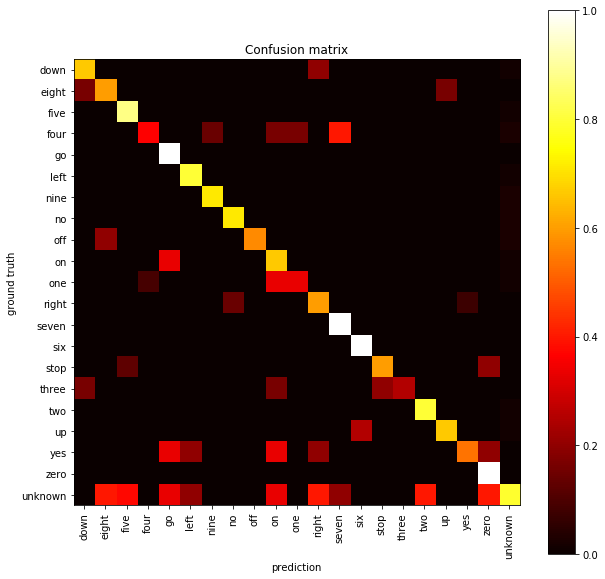

In [40]:
plot_confusion_matrix(y_adapted,y_predict_adapted[-batch_size:], class_names_main)

## Method Validation

In the previous section we introduced two ways of doing speech classification using graphs. For this purpose one single validation batch of size 200 was classified. To have a better idea on how well the two methods classify data, we will now perform 100 iterations of the above explained code (from feature extraction to prediction). The used code can be found in its entirity in main_pipeline.py. This means that for every iteration an entirely new training set and validation set is created, such that the variance due to good or bad training sets is included in the obtained results.<br>
<br>
In the boxplot shown below we can see the resulting mean accuracy, as well as the variance for both classification methods.


In [41]:
accuracy_mat = semisup_test_all_dataset(features_og, y, batch_size, NEIGHBORS, alpha  = 1e-3, beta = 1e-7, iter_max=100, class_names = class_names)

100%|██████████| 100/100 [3:49:39<00:00, 137.79s/it] 


Text(0,0.5,'Classification accuracy')

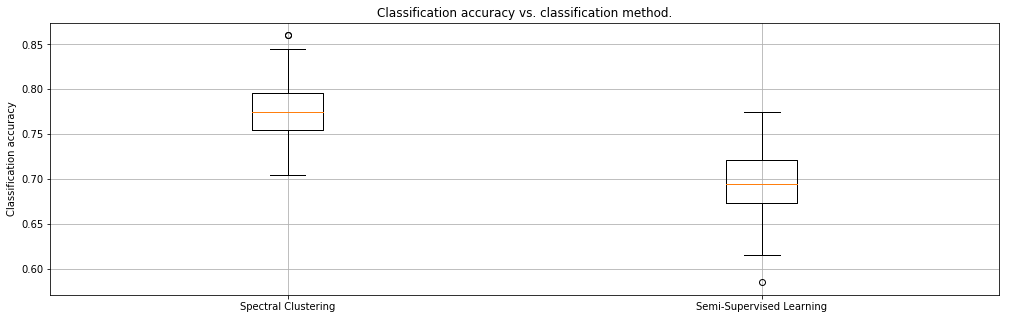

In [42]:
# Display as boxplot
plt.boxplot(accuracy_mat.transpose(), labels = ['Spectral Clustering','Semi-Supervised Learning'])
plt.grid()
plt.title('Classification accuracy vs. classification method.')
plt.ylabel('Classification accuracy')

In [50]:
print('Using spectral clustering a mean accuracy of {}, with a variance of {} could be achieved.'.format(round(np.mean(accuracy_mat[0,:]),2),round(np.var(accuracy_mat[0,:]),4)))
print('Using semi-supervised classification a mean accuracy of {}, with a variance of {} could be achieved.'.format(round(np.mean(accuracy_mat[1,:]),2),round(np.var(accuracy_mat[1,:]),4)))

Using spectral clustering a mean accuracy of 0.78, with a variance of 0.0011 could be achieved.
Using semi-supervised classification a mean accuracy of 0.7, with a variance of 0.0013 could be achieved.


## Conclusion

We introduced two methods to classify word using graph theory. We saw that spectral clustering with an average accuracy of 78% performs better than semi-supervised learning with an average accuracy of 70%. However, eve though the methods currently have similar computation time, in theory semi-superised learning could be implemented to be significantly faster, since it works with sparse representations of the graph, where spectral clustering works best usin a dense graph.<br>
<br>
Even though, we could achieve respectable classification results, we could not come close to state of the art accuracies for the same task (ca. 90%). Still, if we take our mean accuracy score of 78% and assume that it would have performed similairly on the testing set of the kaggle competition a rank amongst the top 50 teams would have been achieved.<br>
<br>
Several steps were integral in improving the performance of our classification. We started out with applying spectral clustering directly on the mfcc statistics (assignment 3) of the raw audio data. With this we achieved roughly 30% - 40% accuracy. Two large steps forward could be achieved by extracting the words from the audio files (circa 10%), as well as using the raw mfccs, dynamically adapted to the length of the spoken word, as defined above (circa 15%). Playing with the sparsity of the Laplacian was critical to achieve good results for both methods. Finally, finding the optimal training size to batch size ratio of 4 to 5% was imperative for the achieved results. <br>
<br>
For spectral clustering, using a dense graph, reducing the size of the eigenvectors and using a good classifier (QDA was found to be optimal) were the main points for achieving our current results. For the semi-supervised classification to work at all it was imperative to add l2 regularization to the optimization, otherwise the problem was often ill-posed. <br>
<br>
Further research on this topic would include a more thorough benchmarking of the different hyperparameters (especially for semi-supervised clustering). Furthermore it would have been interesting to try out other methods, such as the graph inference techniques mentioned in the last lecture. 